In [20]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<center><img src="Header.png"/></center>

<center><h1 style="color:#722502">Uncovering Ingredient-based Clusters among Popular Filipino Dishes</h1></center>

In [1]:
# For data prep
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
from collections import Counter, OrderedDict

# For PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import bisect

# For Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# For plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *

# For writeup
from IPython.display import HTML
from IPython.core.display import HTML as Center
import warnings
warnings.filterwarnings('ignore')

In [2]:
proj_theme = theme(
    strip_background=element_rect(fill="white"),
    legend_title=element_blank(),
    legend_text=element_text(size=9),
    legend_position=(0.5, 0.93),
    legend_direction="horizontal",
    legend_box_background=element_rect(
        fill="transparent", color="transparent"
    ),
    axis_text_x=element_text(size=11, color="#722502"),
    axis_text_y=element_text(size=11, color="#722502", face="bold"),
    text=element_text(family="sans", color="#722502", size=18),
    axis_title_x=element_text(
        color='#DA4D2E', size=12, face="bold", margin={'t': 15}
    ),
    axis_title_y=element_text(
        color='#DA4D2E', size=12, face="bold", margin={'r': 15}
    ),
    plot_title=element_text(
        hjust=0.5, size=14, face="bold", margin={'b': 33}
    ),
    panel_spacing=0.5,
    panel_background=element_rect(fill="white", color="#722502"),
    plot_background=element_rect(fill="white"),
    panel_grid_major_x=element_line(colour="white"),
    panel_grid_major_y=element_line(colour="#cfa544", linetype="dashed"),
    panel_grid_minor=element_blank(),
    strip_text_x=element_text(
        size=14, hjust=0.5, color="#722502", face="bold"
    )
)

In [3]:
def get_dish_urls():
    """Retrieve URLS for dishes under chicken, pork, and beef categories

    Returns
    -------
    dish_urls: dict
        Dictionary containing dish names as keys and URLs as values
    """
    # Limit main ingredients to three types of meat
    meats = ['chicken', 'pork', 'beef']

    # Prepare dish URLs holder
    dish_urls = {}

    # Loop through each meat types
    for meat in meats:

        # Get HTML for the category page
        response = requests.get(
            f'https://panlasangpinoy.com/{meat}-recipes/'
        )
        soup = BeautifulSoup(response.text)

        # Get number of pages
        pagination = soup.select_one(
            "div[class='archive-pagination pagination']"
        )
        last_page = pagination.select_one(
            "li[class='pagination-omission'] + li"
        )
        num_pages = int(last_page.select_one("a").contents[1])

        # Loop through each pages per meat type
        for n in np.arange(1, num_pages+1):
            response = requests.get(
                f'https://panlasangpinoy.com/{meat}-recipes/page/{n}/'
            )
            soup = BeautifulSoup(response.text)

            # Store dish URL
            for dish in soup.select("a[class='entry-title-link']"):
                dish_name = dish.contents[0]
                dish_urls[dish_name] = dish['href']

    print("Extraction of URLs done. Total number of dishes:", len(dish_urls))

    return dish_urls


def get_ingredients(dish_urls):
    """Get ingredients for all dishes

    Parameters
    ----------
    dish_urls: dict
        Dictionary containing dish names as keys and URLs as values

    Returns
    -------
    dish_dict: dict
        Dictionary containing dish names as keys and a dictionary of dish
        information and ingredients as their values
    """
    # Prepare dictionary
    dish_dict = {}

    # Get all dish information and ingredients per dish
    for key, url in dish_urls.items():
        print("Getting details for: ", key)
        response = requests.get(url)
        soup = BeautifulSoup(response.text)

        dish_details = {}

        try:
            dish_details['course'] = soup.select_one(
                "span[class='wprm-recipe-course "
                "wprm-block-text-normal']"
            ).contents[0]
        except AttributeError:
            dish_details['course'] = np.nan

        try:
            dish_details['cuisine'] = soup.select_one(
                "span[class='wprm-recipe-cuisine "
                "wprm-block-text-normal']"
            ).contents[0]
        except AttributeError:
            dish_details['cusine'] = np.nan

        try:
            dish_details['prep_time'] = soup.select_one(
                "span[class='wprm-recipe-details-label wprm-block-text-bold "
                "wprm-recipe-time-label wprm-recipe-prep-time-label'] + span"
            ).text
        except AttributeError:
            dish_details['prep_time'] = np.nan

        try:
            dish_details['cook_time'] = soup.select_one(
                "span[class='wprm-recipe-details-label wprm-block-text-bold "
                "wprm-recipe-time-label wprm-recipe-cook-time-label'] + span"
            ).text
        except AttributeError:
            dish_details['cook_time'] = np.nan

        try:
            dish_details['total_time'] = soup.select_one(
                "span[class='wprm-recipe-details-label wprm-block-text-bold "
                "wprm-recipe-time-label wprm-recipe-total-time-label'] + span"
            ).text
        except AttributeError:
            dish_details['total_time'] = np.nan

        try:
            servings = soup.select_one(
                "span[class='wprm-recipe-details-label wprm-block-text-bold "
                "wprm-recipe-servings-label']"
            ).next_sibling.text
            dish_details['servings'] = int(re.findall(r'\d+', servings)[0])
        except AttributeError:
            dish_details['servings'] = np.nan

        try:
            dish_details['calories'] = soup.select_one(
                "span[class='wprm-recipe-nutrition-with-unit']"
            ).text
        except AttributeError:
            dish_details['calories'] = np.nan

        # Loop through all ingredients
        for ing in soup.select("li[class='wprm-recipe-ingredient']"):
            ing_name = ing.select_one(
                "span[class='wprm-recipe-ingredient-name']"
            ).text
            try:
                str_amount = ing.select_one(
                    "span[class='wprm-recipe-ingredient-amount']"
                ).text
                str_unit = ing.select_one(
                    "span[class='wprm-recipe-ingredient-unit']"
                ).text
                # Determine total numerical weight
                dish_details[ing_name] = get_weight(str_amount, str_unit)
            except AttributeError:
                # Attempt to extract amount and unit from line
                dish_details[ing_name] = get_weight(ing_name, ing_name)

        dish_dict[key] = dish_details

    return dish_dict


def get_weight(str_amount, str_weight):
    """Transform different measurements into base units

    Parameters
    ----------
    str_amount: str
        Numeric amount

    str_weight: str
        Unit of measurement

    Returns
    -------
    weight: int
        Total calculated weight
    """
    amount = 0
    div_weight = 1

    # Set dictionary of vulgar fraction unicode characters
    vul_frac = {
        '¼':1/4,
        '½':.5,
        '¾':3/4,
        '⅐':1/7,
        '⅑':1/9,
        '⅒':.1,
        '⅓':1/3,
        '⅔':2/3,
        '⅕':.2,
        '⅖':.4,
        '⅗':.6,
        '⅘':.8,
        '⅙':1/6,
        '⅚':5/6,
        '⅛':1/8,
        '⅜':3/8,
        '⅝':5/8,
        '⅞':7/8
    }

    # Check for vulgar fraction characters
    for vul_char, frac in vul_frac.items():
        if str_amount.find(vul_char) != -1:
            amount += frac
            break

    # Check for typed fractions
    frac_list = re.findall(r'(\d+)/(\d+)', str_amount)
    if frac_list != []:
        num_frac, den_frac = frac_list[0]
        amount += int(num_frac) / int(den_frac)

    # Check for whole number
    whole_num_list = re.findall(r'(?<!/)(\d+)(?!/)', str_amount)
    if whole_num_list != []:
        amount += int(whole_num_list[0])

    # Add one if amount is detected
    if amount == 0:
        amount += 1

    # Set unit-value mappings
    unit_list = {
        'lb': 0.00220462,
        'bunch': 0.1,
        'liter': 0.236588,
        'quart': 0.25,
        'pinch': 0.355625,
        'pint': 0.5,
        'oz': 8,
        'ounce': 8,
        'thumb': 9.5,
        'tablespoon': 16,
        'tbsp': 16,
        'tsp': 48,
        'ml': 236.588
    }

    # Check for units
    for unit_name, unit_val in unit_list.items():
        if str_weight.find(unit_name) > -1:
            div_weight = unit_val

    # Compute weight
    weight = amount / div_weight

    return weight


def prepare_df(dish_dict):
    '''Create DataFrame out of dish dictionary

    Parameters
    ----------
    dish_dict: dict
        Dictionary containing dish names as keys and a dictionary of dish
        information and ingredients as their values

    Returns
    -------
    df_new: DataFrame
        DataFrame with rows representing dishes and columns representing
        dish information and ingredients
    '''
    # Prepare DataFrame
    df_ing = pd.DataFrame.from_dict(dish_dict).T
    # Retain Filipino dishes
    df_ing = df_ing[df_ing.cuisine.str.contains('Filipino', na=False)]
    # Drop irrelevant columns
    df_ing = df_ing.drop(columns=["course", "cuisine", "prep_time",
                                  "cook_time", "total_time", "servings",
                                  "calories"])
    # Sort columns and drop empty columns
    df_ing = df_ing.sort_index(axis=1)
    df_ing = df_ing.dropna(axis=1, how='all')
    df_ing.fillna(0)

    # Prepare ingredient-keyword mappings
    cat_ing_dict = {
        'yeast': r'(yeast)',
        'wrapper': r'(wrapper)',
        'worcestershire_sauce': r'(worcestershire)',
        'winged_bean': r'(winged bean)',
        'vinegar': r'(vinegar)',
        'turmeric': r'(tumeric)',
        'tomato': r'(tomato)',
        'tofu': r'(tofu)',
        'toasted_rice_powder': r'(toasted rice powder)',
        'taro': r'(taro)',
        'sweet_potato': r'(sweet potato)',
        'sugar': r'(sugar)',
        'star_anise': r'(star anise)',
        'squash': r'(kalabasa|squash)',
        'soy_sauce': r'(soy sauce)',
        'sinigang_mix': r'(sinigang)',
        'shortening': r'(shortening)',
        'sesame_oil': r'(sesame oil)',
        'scallion': r'(scallion)',
        'sayote': r'(sayote)',
        'salted_egg': r'(salted egg)',
        'safflower_oil': r'(safflower oil)',
        'raisins': r'(raisins)',
        'radish': r'(radish)',
        'potato': r'(potato)',
        'pork_insides': (
            r'(pig’s liver|pig’s heart|pig’s small intestine|'
            r'bung|pig cheeks|pig heart|pig kidney|pig stomach|'
            r'pork ears|pork large intenstine|pork liver|small intestine)'
        ),
        'pork_fat': r'(pork fat)',
        'pork_stock': r'(pork broth|pork stock|pork cube)',
        'pork_blood': r'(pork blood)',
        'pork_and_beans': r'(pork and beans)',
        'pie_crust': r'(pie)',
        'pickle': r'(pickle|relish)',
        'pepper_leaf': r'(pepper leaves)',
        'pechay': r'(pechay)',
        'peanut': r'(peanut)',
        'patola': r'(patola)',
        'parsley': r'(parsley)',
        'paprika': r'(paprika)',
        'papaya': r'(papaya)',
        'oyster_sauce': r'(oyster)',
        'onion': r'(onion)',
        'olive_oil': r'(olive oil)',
        'olive': r'(olive)',
        'okra': r'(okra)',
        'nutmeg': r'(nutmeg)',
        'noodle': r'(noodle|pancit|sotanghon|misua|miswa)',
        'mushroom': r'(mushroom)',
        'munggo': r'(mung)',
        'mirin': r'(mirin)',
        'mayonnaise': r'(mayonnaise)',
        'malunggay': r'(malunggay)',
        'liver_spread': r'(liver)',
        'lemongrass': r'(lemongrass)',
        'leeks': r'(leeks)',
        'lechon_sauce': r'(lechon)',
        'kasubha': r'(kasubha)',
        'kangkong': r'(spinach|kangkong)',
        'jicama': r'(jicama)',
        'jackfruit': r'(jackfruit)',
        'ice': r'(ice)',
        'hotdog': r'(hotdog)',
        'hot_sauce': r'(hot)',
        'honey': r'(honey)',
        'hoisin_sauce': r'(hoisin)',
        'green_pea': r'(green pea|pigeon pea)',
        'green_bean': (
            r'(green beans|sitaw|snake beans|string beans|snap pea|snow pea)'
        ),
        'glutinous_rice': r'(glutinous rice)',
        'ginger': r'(ginger)',
        'ginataang_gulay_mix': r'(ginataang)',
        'garlic': r'(garlic)',
        'flour': r'(flour)',
        'eggplant': r'(eggplant|talong)',
        'egg': r'(egg)',
        'curry_powder': r'(curry)',
        'cucumber': r'(cucumber)',
        'cream': r'(cream)',
        'cooking_wine': r'(wine)',
        'cooking_oil': r'(cooking oil|vegetable oil)',
        'coconut_water': r'(coconut water)',
        'coconut_milk': r'(coconut cream|coconut milk)',
        'coconut_meat': r'(coconut meat)',
        'clear_soda': r'(7-up|sprite|clear softdrink)',
        'cinnamon': r'(cinnamon)',
        'sausage': r'(chinese sauage|chorizo)',
        'chicken_stock': r'(chicken broth|chicken cube)',
        'chicharon': r'(chicharon)',
        'cheese': r'(cheese)',
        'celery': r'(celery)',
        'carrot': r'(carrot)',
        'canned_meat': r'(potted meat|luncheon meat)',
        'calamansi': r'(calamansi|lemon|lime)',
        'cabbage': r'(cabbage)',
        'butter': r'(butter|margarine)',
        'broccoli': r'(broccoli)',
        'bread': r'(bread)',
        'bok_choy': r'(bok choy|bokchoy)',
        'black_soda': r'(coke|cola)',
        'black_bean': r'(black bean)',
        'beer': r'(beer)',
        'beef_insides': (
            r'(lard|cow|beef heart|beef kidney|beef large instestine|'
            r'beef liver|beef neck bone|beef small intestine|bile|tripe|'
            r'tongue|tripe|lengua)'
        ),
        'beef_stock': (
            r'(beef cube|beef bouillon|bulalo|beef broth|beef stock)'
        ),
        'bay_leaf': r'(bay)',
        'bamboo_shoots': r'(bamboo shoots)',
        'baking_powder': r'(baking powder)',
        'annatto': r'(annatto)',
        'ampalaya': r'(ampalaya)',
        'adobo_sauce': r'(adobo)',
        'achiote': r'(achiote)',
        'tomato_liquid': (
            r'(ketchup|tomato sauce|tomato paste|spaghetti sauce)'
        ),
        'banana_flower': r'(blossom)',
        'pepper': r'(white pepper|black pepper|crushed pepper|peppercorn)',
        'chili': (
            r'(chili|pepper flakes|serrano pepper|sili|jalapeno|'
            r'ghost pepper|green pepper)'
        ),
        'bell_pepper': r'(bell pepper)',
        'bagoong': r'(alamang|shrimp paste|balaw)',
        'liquid_seasoning': r'(liquid seasoning|savorrich|marinade)',
        'chickpea': r'(chick pea|garbanzos)',
        'chicken_insides': r'(chicken gizzard|chicken hear|chicken liver)',
        'cornstarch': r'(cornstarch)',
        'corned_beef': r'(corned beef)',
        'fish_sauce': r'(fish sauce)',
        'pineapple_juice': r'(pineapple juice|juice from the canned tidbits)',
        'shrimp_cube': r'(shrimp cube)',
        'watermelon': r'(watermelon)',
        'milk': r'(milk)',
        'pea': r'(pea)',
        'pasta': r'(spaghetti|macaroni)',
        'shrimp': r'(shrimp)',
        'pineapple': r'(pineapple)',
        'water': r'(water)',
        'salt': r'(salt)',
        'rice': r'(rice|sinangag)',
        'pork': r'(pork|pig|lechon)',
        'corn': r'(corn)',
        'chicken': r'(chicken)',
        'beef': r'(beef|steak|oxtail|ox tail|sirloin|bistek)',
        'banana': r'(banana|plantain)'
    }

    # Create new DataFrame
    df_new = pd.DataFrame(index=df_ing.index)

    # Loop through the categories
    for cat_name, cat_regex in cat_ing_dict.items():
        # Look for columns that contains the query
        ing_filter = (
            df_ing.columns.to_series()
            .str.contains(cat_regex, case=False, regex=True)
        )

        # Filter columns that satisfy the query
        filter_cols = ing_filter[ing_filter].index

        print(f"Columns obtained for {cat_name}:", filter_cols)

        # Add columns to the new DataFrame
        df_new[cat_name] = df_ing[filter_cols].sum(axis=1)

        # Drop columns to prevent reusing of ingredients
        df_ing.drop(columns=filter_cols, inplace=True)

    df_new = df_new.rename_axis('dish_name').reset_index()
    return df_new


def retrieve_data():
    '''Get tables from database

    Returns
    -------
    df_ing, df_nut: DataFrame
        DataFrames representing ingredients and nutrional value, respectively
    '''
    with create_engine('sqlite:///ulam.db').connect() as conn:
        # Read ingredients table
        df_ing = pd.read_sql("""
        SELECT * FROM rekado
        """, conn)

    return df_ing


def drop_features(data, irrelevant_cols, skip_cols, p):
    """
    Drop features given a variance threshold

    Parameters
    ----------
    data : dataframe
        dataframe from which the columns will be dropped. May contain
    a mix of numeric and categorical columns. By default, categorical
    columns are label-encoded before getting the variance of the columns.

    irrelevant_cols : list
        list of column names. Column names in this list will be dropped
    permanently.

    skip_cols : list
        list of column names. Column names in this list will be kept by
    default and will not undergo variance thresholding.

    p : float
        variance threshold for dropping. A p = 0.01 would mean dropping
    columns where 99% of the values are similar.

    Returns
    -------
        dataframe in its original format, whose columns that did not
    satisfy the p threshold were dropped

    """
    orig_data = data.copy(deep=True)
    if irrelevant_cols is not None:
        data = orig_data.drop(irrelevant_cols, axis=1)
    if skip_cols is not None:
        data = data.drop(skip_cols, axis=1)

    num_data = pd.DataFrame(data.select_dtypes(include=np.number))
    cat_data = pd.DataFrame(data.select_dtypes(exclude=np.number))

    if cat_data.shape[1] != 0:
        cat_data = cat_data.apply(LabelEncoder().fit_transform)
        transformed_data = pd.concat([num_data, cat_data], axis=1)
    else:
        transformed_data = num_data

    # threshold=0.01 means dropping the column where 99% of values are similar.
    thresh = VarianceThreshold(threshold=p)
    thresh.fit_transform(transformed_data)
    ind = thresh.get_support(indices=True)
    cols_kept = list(transformed_data.columns[ind])
    cols_dropped = list(set(transformed_data.columns)-set(cols_kept))

    if skip_cols is not None:
        return orig_data[skip_cols + cols_kept]

    return orig_data[cols_kept]


def fix_dtypes(data):
    """Fix datatypes of the dataframe

    Parameters
    ----------
    data : dataframe
        dataframe from which the columns will be appropriately
    converted into their correct data types. May contain a mix of numeric
    and categorical columns.

    """
    df = data.copy(deep=True)
    df = df.convert_dtypes()
    for i in df.columns:
        if '_dt' in i:
            df[i] = pd.to_datetime(df[i], errors='coerce')
    return df


def truncated_svd(X, thresh=0.90):
    """Perform singular value decomposition on a design matrix X"""

    q, s, p = np.linalg.svd(X, full_matrices=True)
    Q = q
    S = np.diag(s)
    P = p.T
    NSSD = (s / np.sqrt(np.sum(s**2)))**2

    ind = bisect.bisect(NSSD.cumsum(), thresh) + 1

    return Q, S, P, NSSD


def project_svd(q, s, k):
    """Project the design matrix on to the first k singular vectors"""

    return q[:, :k].dot(s[:k, :k])


def plot_svd_ulam(data, num_comp, num_ing, fill_fn, manual_fill_values):
    pc = data.iloc[:, (num_comp-1)].reset_index()
    pc.columns = ['ing', 'loading']
    pc['abs_loading'] = np.abs(pc['loading'])
    pc = pc.sort_values('abs_loading', ascending=False).head(num_ing)
    pc['ing'] = pc['ing'].str.replace('_', ' ').str.title()
    pc['ing'] = pd.Categorical(pc['ing'], categories=pc['ing'], ordered=True)
    pc['ing_color'] = fill_fn(pc['loading'])

    p = (
        ggplot(pc, aes(x='ing', y='loading')) +
        geom_bar(aes(fill='ing_color'), stat='identity', show_legend=False) +
        scale_fill_manual(values=manual_fill_values) +
        coord_flip() +
        xlab('') +
        ylab('') +
        proj_theme
    );

    return p


def final_clustering(transformed_arr,
                     orig_df,
                     method,
                     threshold,
                     plot_threshold,
                     break_biggest_cluster=False,
                     link_colors=['#5594BA',
                                  '#EFC564',
                                  '#DA4D2E',
                                  '#722502',
                                  '#EFC564',
                                  '#B3C55A']):

    Z = hierarchy.linkage(
        transformed_arr, method=method, optimal_ordering=True
    )
    hierarchy.set_link_color_palette(link_colors)
    y_pred = fcluster(Z, t=threshold, criterion='distance')

    if break_biggest_cluster:
        X_cluster = orig_df.copy()
        X_cluster['cluster'] = y_pred

        get_big_cluster = X_cluster.groupby(['cluster']).size().idxmax()
        X_1 = (
            X_cluster[X_cluster.cluster == get_big_cluster]
            .drop(columns='cluster')
        )
        Z_1 = linkage(X_1, method='ward', optimal_ordering=True)
        Z = Z_1

    fig, ax = plt.subplots(figsize=(7.5, 5), dpi=100)

    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.6)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(0.0)

    ax.spines['bottom'].set_color('#722502')
    ax.spines['top'].set_color('#722502')
    ax.spines['right'].set_color('#722502')
    ax.spines['left'].set_color('#722502')
    ax.tick_params(axis='x', colors='#722502')
    ax.tick_params(axis='y', colors='#722502')
    ax.set_ylabel(r'$\Delta$')

    dn = dendrogram(Z, ax=ax, p=plot_threshold, truncate_mode='level')
    fig.show()

    return Z


def plotly_ulam(data, x, y, c, y_ref, x_ref, c_map):
    """Plot the ingredient clustering results on the ingredient SV components

    Projects the dishes on the ingredient SV components and colors them by
    their clustering results. This allows the user to associate
    the natural tendencies of the dishes' ingredients and to the
    natural clustering results.

    Parameters
    ----------
    data : dataframe
        pandas dataframe consisting of the ingredient SVs, along with the
        cluster numbers, cluster names, and the desired cluster colors
    x : str
        Column in data; serves as the x-axis.
    y : str
        Column in data; serves as the x-axis.
    c : str
        Column in data; serves as the color mapping.
    y_ref : float
        y intercept to be plotted.

    x_ref : float
        x intercept to be plotted.

    c_map : dict
        Dictionary that maps the cluster names to a HEX color.

    """

    fig = px.scatter(data.sort_values('cluster_name'),
                     x=x,
                     y=y,
                     color=c,
                     hover_data=['Dish Name'],
                     labels={
                         x: '<b>Meat and Vegetable Range</b>',
                         y: '<b>Flavor Range</b>',
                         c: '<b>Cluster</b>',
                         'Dish Name': '<b>Dish Name</b>'},
                     color_discrete_map=cmap,
                     width=1000, height=800)
    fig.update_traces(marker={'size': 14})
    fig.for_each_trace(
        lambda t: t.update(
            textfont_color='#99D072',
            textposition='top right'
        )
    )
    fig.add_shape(
        yref='y',
        y0=y_ref,
        y1=y_ref,   # adding a horizontal line at Y = 1
        xref='paper',
        x0=0,
        x1=1,
        line=dict(
            color='rgba(114, 37, 2, 0.5)',
            width=2.5)
    )
    fig.add_shape(
        type='line',
        yref='paper',
        y0=0,
        y1=1,
        xref='x',
        x0=x_ref,
        x1=x_ref,
        line=dict(
            color='rgba(114, 37, 2, 0.5)',
            width=2.5)
    )
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
        font={'size': 20, 'color': '#722502'},
        plot_bgcolor='white',
        xaxis_range=[-1.3, 1.3],
        yaxis_range=[-1.3, 1.3],
        paper_bgcolor='white'
    )
    fig.update_xaxes(
        showline=True, linewidth=2, linecolor='#722502', gridcolor='#F7E2B1'
    )
    fig.update_yaxes(
        showline=True, linewidth=2, linecolor='#722502', gridcolor='#F7E2B1'
    )
    fig.show()


def get_cluster_ing(data, cluster_list):
    """Get the unique ingredients per cluster in the list

    For each cluster in the cluster list, return a list of
    unique ingredients.

    Parameters
    ----------
    data : dataframe
        pandas dataframe consisting of the original ingredient values,
    along with the cluster number and names.

    cluster_list: list
        list of clusters from which ingredients will be taken.

    """
    pantry_ing = []
    for c in cluster_list:
        def get_ingredient(x):
            x = x.astype(float)
            return x[x > 0].index.tolist()
        cluster_df = (
            data[data['cluster_name'] == c]
            .drop(['cluster', 'cluster_no', 'cluster_name'], axis=1)
        )
        ing_df = cluster_df.apply(get_ingredient, axis=1).reset_index()
        slist = []
        for x in ing_df.iloc[:, 1]:
            slist.extend(x)
        cluster_ing = sorted(set(slist))
        pantry_ing += [cluster_ing]
    pantry_ing = dict(zip(cluster_list, pantry_ing))

    return pantry_ing


def plot_var(variance_explained, num_components):
    """
    Plot the individual and cumulative variance explained of the resulting PCs.

    Parameters
    ----------
    variance_explained : array
        Eigenvalues of the PCs.
    num_components : int or float
        Number of components to keep; to be imposed on with a horizontal
    dashed line.
    species_str : str
        String to be placed in the plot title.

    """
    var_ind = pd.DataFrame(zip(range(1, len(variance_explained)+1),
                                   ['Individual']*len(variance_explained),
                                   variance_explained),
                               columns=['SV', 'Contribution', 'Value'])
    var_cum = pd.DataFrame(zip(range(1, len(variance_explained)+1),
                                   ['Cumulative']*len(variance_explained),
                                   variance_explained.cumsum()),
                               columns=['SV', 'Contribution', 'Value'])
    var = pd.concat([var_ind, var_cum], axis=0)
    value = var['Value']*100
    var['Contribution %'] = (value).round(2).astype(str) + '%'
    var['Value'] = var['Value']*100

    fig = px.line(var, x='SV', y='Value', color='Contribution',
                  hover_data={'SV': False,
                              'Contribution': False,
                              'Value': False,
                              'Contribution %': True},
                  markers=True, color_discrete_map={'Individual': '#EFC564',
                                                    'Cumulative': '#DA4D2E'})
    fig.update_layout(
            xaxis_title="<b>Number of SV</b>",
            yaxis_title="<b>Variance Explained</b>",
            margin=dict(l=0, r=0, t=50, b=0),
            font={'size': 14, 'color': '#722502'},
            plot_bgcolor='white',
            yaxis_range=[0, 100],
            hovermode="x",
            height=500,
            width=800)
    fig.add_shape(
            type='line',
            yref='paper',
            y0=0,
            y1=1,
            xref='x',
            x0=num_components,
            x1=num_components,
            line=dict(
                color='#722502',
                dash='dash',
                width=2))
    fig.update_yaxes(
        showline=True, linewidth=2, linecolor='#722502', gridcolor='#F7E2B1'
    )
    fig.update_xaxes(
        showline=True, linewidth=2, linecolor='#722502', gridcolor='white'
    )
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        title='<b>Contribution</b>'
    ))

    return fig

<h1 style="color:#722502">Executive Summary</h1>

Alam mo ba kung ano ang pinagkaiba ng Caldereta, Menudo, Mechado, at Afritada? Hindi? Kami rin! 

Inspired by the ambiguity surrounding the Menudo-Afritada-Caldereta-Mechado debate, our team performed dimensionality reduction and clustering methods on Panlasang Pinoy's recipes to understand our very own Filipino dishes from an ingredient-list standpoint. Through singular value decomposition (SVD), the natural combinations of ingredients used when cooking Filipino dishes were identified, and were subsequently used in creating the ulam clusters. Out of all the clustering methods explored, Ward's provided the best visual and domain knowledge interpretation while still retaining parsimony. Overall, this study offers two sets of findings: (1) ingredient-based clusters of Filipino dishes and their corresponding interpretation, and (2) the data-driven definition of a Filipino pantry, which houses easily accessible ingredients that are assured to produce a Filipino favorite every time it is used.

The team discovered seven main ulam clusters: Sour soup cluster or the Sinigang cluster has a soup with a sour taste and contains leafy vegetables and beans. Saucy crops cluster are dishes with tomato or coconut milk-based sauce with potatoes and carrots. Salty soup is characterized by the salty soup taste and usually comes with leafy vegetables, potatoes, and carrots. Nutty Sauce is characterized by its peanut-y taste and usually comes with leafy vegetables and eggplant. Soy vinegar comes with soy and vinegar-based sauce or a dip made from the same condiments. Red sweet uses Pinoy-style sauces and banana ketchup as the base of the sauce. Soy sweet has sauces that are soy and sugar-based. As the group interpreted the dishes based on how they were grouped, we also gathered ingredients that were present in almost all clusters, put them together, and finally unlocked the data-driven definition of the Filipino pantry.

What started as supposedly just a fun activity to do turned into a full-blown project for us. As we got the results, practical applications and potential business values are apparent. For the Filipino household, families can identify cost-efficient combination of dishes that use the same ingredients to serve at home or during occasions. For the food industries, creating a good menu with a right balance of contrasting flavors, as well as reinventing traditional Filipino recipes, are now supplemented with data-driven insights. Finally, for everyone in between, the checklist of Filipino pantry must-haves is now available to accompany and prepare us whenever we crave for an authentic Filipino dish.

<h1 style="color:#722502">Introduction</h1>

<h2 style="color:#DA4D2E">Background</h2>

What dish would you say the specialty of the Philippines? Everyone knows that sushi is Japanese and Italy is where pasta rules, but what kind of food could you say define the Philippine cuisine? The answer is we do not know. 

Hailed as the original fusion cuisine [[1]](#ref1), the aromas, flavors, and colors of the Filipino food make up an intricate tapestry of the richness of our own history. Contrary to most of our Southeast Asian neighbors, Filipino dishes usually shy away from using herbs and are inclined to use unique ingredients like offal, gizzard, and chicken intestines. Apart from having a variety of ingredients, the style of making Filipino dishes pulls a lot from Spanish and American influences, as well as Asian influences such as Chinese and Indonesian [[2]](#ref2). Even at the local level, the same dish gets a different take and interpretation across different regions, and even within the same neighborhood. 

Intrigued by how such diverse combination of ingredients and cooking techniques work together, our group decided to evaluate the current situation of our very own Filipino dishes. Using the recipes from Panlasang Pinoy website, this study aims to discover the underlying patterns of our dishes from an ingredient standpoint, and from there create ingredient-based ulam clusters. The group believes that by understanding the clusters from an ingredient standpoint, we can identify cost-efficient combination of dishes to serve on occasions, create a good menu with a right balance of contrasting flavors, and directly interpret spaces in between clusters as avenues for both innovation and reinvention of our traditional recipes. Further, as a direct extension of the clustering results, this study also aims to construct perhaps the very first data-driven definition of the “Filipino Pantry.” This pantry is expected to house easily accessible ingredients that are assured to produce a Filipino favorite every time it is used.

Ultimately, this work serves as a data-driven celebration of the diversity, creativeness, and boldness of the Filipino cuisine, which the group would like to share to anyone interested in the Filipino culture, or simply, to anyone who enjoys food! Are you excited to know what's in your ulam, pare?


<h2 style="color:#DA4D2E">Problem Statement</h2>

How do the Filipino dishes look like from an ingredient-list standpoint? Particularly:

<ol>
<li>How do the ingredient-based clusters describe the Filipino dishes in terms of flavor, consistency, and vegetable content?
<li>Are there persistent ingredients across the clusters that could possibly describe the contents of a "Filipino Pantry"?</li>
</ol>

<h1 style="color:#722502">Data Sources and Description</h1>

The study used the recipes from Panlasang Pinoy; a Filipino food blog created by Mr. Vanjo Merano to showcase his passion for cooking and promote Filipino Cuisine to the rest of the world. Each Filipino dish page is presented in a blog-like fashion, complete with a narrative, cooking tips, and of course the recipe itself. The recipe contains brief information about the dish, cooking utensils and equipment needed, ingredients, and instructions (Figure 1). Some recipes are also accompanied by their estimated nutritional value based on the said ingredients. Compared to other sources, the units of both the ingredients and nutritional content in this website are relatively more standardized. Out of all this information, only the ingredients list with their corresponding units was scraped.

<center><img src="recipes.png"/></center>

<center><i>Figure 1. Sample Recipes from Panlasang Pinoy</i></center>



<h2 style="color:#DA4D2E">Ingredient Dataset</h2>

The ingredient lists for the different Filipino dishes were compiled into the Ingredient Dataset. Its rows corresponds to a dish, while each of its columns correspond to an ingredient. Ingredients that do not appear in the dish were assigned a value of 0. Further, ingredients that represent almost the same flavor and texture were collapsed (e.g., `black pepper` and `peppercorn` were collapsed into `pepper`). Table 1 below lists down all the ingredients that can be found in the dataset, grouped according to their kind.

<br>

<center><i>Table 1. Column Names of the Ingredient Information Dataset</i></center>

|<center><b>Meat</b></center>|<center><b>Grains, Fruits, and Veggies</b></center>|<center><b>Base Liquids</b></center>|<center><b>Herbs, Spices, and Condiments</b></center>|
|:---|:---|:---|:---|
|`beef_insides`|`ampalaya`|`beef_stock`|`achiote`|
|`beef`|`bamboo_shoots`|`beer`|`adobo_sauce`|
|`canned_meat`|`banana`|`black_soda`|`annatto`|
|`chicharon`|`bell_pepper`|`chicken_stock`|`bagoong`|
|`chicken_insides`|`black_bean`|`clear_soda`|`baking_powder`|
|`chicken`|`bok_choy`|`coconut_milk`|`banana_flower`|
|`corned_beef`|`bread`|`ice`|`bay_leaf`|
|`egg`|`broccoli`|`milk`|`butter`|
|`hotdog`|`cabbage`|`pineapple_juice`|`calamansi`|
|`pork_and_beans`|`carrot`|`pork_stock`|`cheese`|
|`pork_blood`|`celery`|`tomato_liquid`|`chili`|
|`pork_fat`|`chickpea`|`water`|`cinnamon`|
|`pork_insides`|`coconut_meat`||`coconut_water`|
|`pork`|`corn`||`cooking_oil`|
|`salted_egg`|`cucumber`||`cooking_wine`|
|`sausage`|`eggplant`||`cornstarch`|
|`shrimp`|`glutinous_rice`||`cream`|
||`green_bean`||`curry_powder`|
||`green_pea`||`fish_sauce`|
||`jackfruit`||`flour`|
||`jicama`||`garlic`|
||`kangkong`||`ginataang_gulay_mix`|
||`malunggay`||`ginger`|
||`munggo`||`hoisin_sauce`|
||`mushroom`||`honey`|
||`noodle`||`hot_sauce`|
||`okra`||`kasubha`|
||`olive`||`lechon_sauce`|
||`papaya`||`leeks`|
||`pasta`||`lemongrass`|
||`patola`||`liquid_seasoning`|
||`pea`||`liver_spread`|
||`peanut`||`mayonnaise`|
||`pechay`||`mirin`|
||`pepper_leaf`||`nutmeg`|
||`pickle`||`olive_oil`|
||`pie_crust`||`onion`|
||`pineapple`||`oyster_sauce`|
||`potato`||`paprika`|
||`radish`||`parsley`|
||`raisins`||`pepper`|
||`rice`||`safflower_oil`|
||`sayote`||`salt`|
||`squash`||`scallion`|
||`sweet_potato`||`sesame_oil`|
||`taro`||`shortening`|
||`tofu`||`shrimp_cube`|
||`tomato`||`sinigang_mix`|
||`watermelon`||`soy_sauce`|
||`winged_bean`||`star_anise`|
||`wrapper`||`sugar`|
||||`toasted_rice_powder`|
||||`turmeric`|
||||`vinegar`|
||||`worcestershire_sauce`|
||||`yeast`|

<br>

To allow better comparability and interpretation, the unit of measurements underwent a two-step scaling method (see Data Preparation for more details). In this way, all dry ingredients in the dataset are measured in grams, all wet ingredients are measured in cups, and all ingredients that come in packs and bundles (e.g., dozen) are measured in individual count of pieces.

<h2 style="color:#DA4D2E">Creating the Filipino Dishes Database</h2>

The team created an SQLite database, named `ulam.db`, consisting of the Ingredients table that have the relevant and necessary information to answer all the study's research questions.  Table 3 below summarizes the contents of the database, followed by a preview of the mentioned table.

<br>

<center><i>Table 2. Filipino Dishes Database Content Summary</i></center>

| <center><b>Attribute</b></center> | <center><b>Information</b></center> |
|:---|:---|
| Total number of Filipino dishes | 282 dishes |
| Total number of pork dishes | 138 dishes |
| Total number of chicken dishes | 81 dishes |
| Total number of beef dishes | 56 dishes |
| Total number of ingredients | 137 ingredients | 

<center><i>Table 3. Ingredient Information Table Preview</i></center>

In [4]:
df_ing = retrieve_data()
df_ing.head()

dish_name  yeast  wrapper  worcestershire_sauce  \
0           Sinarsahang Manok    0.0      0.0                   0.0   
1  Pinoy Chicken Curry Recipe    0.0      0.0                   0.0   
2       Ketchup Fried Chicken    0.0      0.0                   0.0   
3            Chicken Barbecue    0.0      0.0                   0.0   
4       Chicken Paksiw Recipe    0.0      0.0                   0.0   

   winged_bean  vinegar  turmeric  tomato  tofu  toasted_rice_powder  ...  \
0          0.0   0.0000       0.0     2.5   0.0                  0.0  ...   
1          0.0   0.0000       0.0     0.0   0.0                  0.0  ...   
2          0.0   0.3125       0.0     0.0   0.0                  0.0  ...   
3          0.0   0.0000       0.0     0.0   0.0                  0.0  ...   
4          0.0   0.5000       0.0     0.0   0.0                  0.0  ...   

   shrimp  pineapple  water  salt  rice  pork  corn     chicken  beef  banana  
0     0.0        0.0    1.5   0.0   0.0   0.0   0.0  680.389364   0.0     0.0  
1     0.0        0.0    1.0   0.0   0.0   0.0   0.0  907.185819   0.0     0.0  
2     0.0        0.0    0.0   0.0   0.0   0.0   0.0    3.000000   0.0     0.0  
3     0.0        0.0    0.0   2.0   0.0   0.0   0.0    4.000000   0.0     0.0  
4     0.0        0.0    1.0   1.0   0.0   0.0   0.0  453.592909   0.0     0.0  

[5 rows x 137 columns]

<h2 style="color:#DA4D2E">Data Assumptions and Limitations</h2>

This study is not without limitations and assumptions. The researchers acknowledge that there are different interpretations for a single Filipino dish and that the ones from Panlasang Pinoy are not to be considered as the gold standard. With that said, the recipes in this study came ultimately rely on the interpretation of the website's owner and contributors. The researchers also have to impose an assumption that the conversion multipliers used in correspondingly scaling all ingredients into grams (dry), cups (wet), and pieces (bundles) are correct.

As we want to allow the algorithms to learn the underlying patterns beyond merely the protein types, we only included considered pork, chicken, and beef dishes. Further, we did not inform the algorithm about the techniques used in the dishes (e.g., boiled, braised, etc.), sources of origin (whether cultural or location-based), and whether the dish is a variant of an existing one. While these are valuable information, these are too difficult to define and find proxies for given the limited time for this study.


<h1 style="color:#722502">Methodology</h1>
<br>
This study applied the methodology pipeline described in Figure 2. While the previous sections have given a brief overview to some of the steps below, this section discusses the tasks performed for each step in detail.
<br>
<br>
<center><img src="methods.png" width='80%'/></center>
<br>
<center><i>Figure 2. Methododology Pipeline</i></center>

<h2 style="color:#DA4D2E">Data Preparation</h2>

The following tasks were performed to prepare the Ingredient Dataset for clustering. These tasks span from Web Scraping up until the Dimensionality Reduction phase of the study.

- <b><font color="#8D9F38">Collapsing the ingredient list.</font></b> Multiple ingredients of similar names and nature were initially found in the dataset. To provide an accurate interpretation of results, the team decided to group similar ingredients by looking for certain keywords using regular expression. Table 6 below lists down all the ingredients that have been collapsed (i.e., groups of size greater than 1), along with the keywords used in parsing. For the complete list of ingredients and their corresponding keywords, please see the Appendix.

<center><i>Table 4. Groupings of Ingredients (Group Size > 1) with Corresponding Keywords</i></center>

| <center><b>Ingredient Group (feature)</b></center> | <center><b>Keywords</b></center> |
|:---|:---|
|`pork_insides`| "pig’s liver", "pig’s heart", "pig’s small intestine", "bung", "pig cheeks", "pig heart", "pig kidney", "pig stomach", "pork ears", "pork large intenstine", "pork liver", "small intestine"|
|`pork_stock`| "pork broth", "pork stock", "pork cube"|
|`noodle`| "noodle", "pancit", "sotanghon", "misua", "miswa"|
|`kangkong`| "spinach", "kangkong"|
|`green_pea`| "green pea", "pigeon pea"|
|`green_bean`| "green beans", "sitaw", "snake beans", "string beans", "snap pea", "snow pea"|
|`eggplant`| "eggplant", "talong"|
|`cooking_oil`| "cooking oil", "vegetable oil"|
|`coconut_milk`| "coconut cream", "coconut milk"|
|`clear_soda`| "7-up", "sprite", "clear softdrink"|
|`sausage`| "chinese sauage", "chorizo"|
|`chicken_stock`| "chicken broth", "chicken cube"|
|`canned_meat`| "potted meat", "luncheon meat"|
|`calamansi`| "calamansi", "lemon", "lime"|
|`butter`| "butter", "margarine"|
|`bok_choy`| "bok choy", "bokchoy"|
|`black_soda`| "coke", "cola"|
|`beef_insides`| "lard", "cow", "beef heart", "beef kidney", "beef large instestine", "beef liver", "beef neck bone", "beef small intestine", "bile", "tripe", "tongue", "tripe", "lengua"|
|`beef_stock`| "beef cube", "beef bouillon", "bulalo", "beef broth", "beef stock"|
|`tomato_liquid`| "ketchup", "tomato sauce", "tomato paste", "spaghetti sauce"|
|`pepper`| "white pepper", "black pepper", "crushed pepper", "peppercorn"|
|`chili`| "chili", "pepper flakes", "serrano pepper", "sili", "jalapeno", "ghost pepper", "green pepper"|
|`bagoong`| "alamang", "shrimp paste", "balaw"|
|`liquid_seasoning`| "liquid seasoning", "savorrich", "marinade"|
|`chickpea`| "chick pea", "garbanzos"|
|`chicken_insides`| "chicken gizzard", "chicken hear", "chicken liver"|
|`pineapple_juice`| "pineapple juice", "juice from the canned tidbits"|
|`pasta`| "spaghetti", "macaroni"|
|`rice`| "rice", "sinangag"|
|`pork`| "pork", "pig", "lechon"|
|`beef`| "beef", "steak", "oxtail", "ox tail", "sirloin", "bistek"|
|`banana`| "banana", "plantain"|


-	<b><font color="#8D9F38">Dropping of low-variance ingredients.</font></b> Columns whose values are 99% the same were dropped. These ingredients are `pea`, `leeks`, `cucumber`, `turmeric`, and `glutinous_rice`.


- <b><font color="#8D9F38">Standardizing the ingredient amounts.</font></b> All units of measurement for the ingredients underwent a two-step scaling method: (1) ensuring that all dry ingredients are measured in grams (Table 7), all wet ingredients are measured in cups (Table 8), and all ingredients that come in packs and bundles (e.g., dozen) are measured in an individual count of pieces (Table 9), and afterward (2) applying Min-Max scaling. Min-Max scaling was used to retain the integrity of the positive ingredient amounts.

<center><i>Table 5. Conversion of Units of Measurement for Dry Ingredients</i></center>

| <center><b>Unit</b></center> | <center><b>Equivalent Amount to 1 gram</b></center> |
|:---|:---|
|pounds(lbs.)|0.00220462|
|pinch|0.355625|
|thumb|9.5|

<br> 

<center><i>Table 6. Conversion of Units of Measurement for Wet Ingredients</i></center>

| <center><b>Unit</b></center> | <center><b>Equivalent Amount to 1 cup</b></center> |
|:---|:---|
|liter(L)|0.236588|
|quart(qt)|0.25|
|pint|0.5|
|ounce(oz.)|8|
|tablespoon(tbsp.)|16|
|teaspoon(tsp.)|48|
|milliliter(ml)|236.588|

<br> 

<center><i>Table 7. Conversion of Units of Measurement for Ingredients in Packs</i></center>

| <center><b>Unit</b></center> | <center><b>Equivalent Amount to 1 Piece</b></center> |
|:---|:---|
|pack|1|
|can|1|
|bundle|5|
|dozen|12|


- <b><font color="#8D9F38">Performing dimensionality reduction on the ingredients.</font></b> By the time the Ingredient Dataset has reached the third step, the final set of features stands at 137 ingredients, with a lot of them having a value of 0 (representing the absence of the ingredient in the dish). To reduce the number of features, and ultimately, to understand the natural tendencies of ingredients to group or separate, dimensionality reduction was performed. Since the data is sparse, singular value decomposition (SVD) was used. Given a cumulative variance explained threshold of $90\%$, the researchers kept 60 SV components (Figure 3).

In [5]:
fixed_df = fix_dtypes(df_ing)
dropped_df = drop_features(
    df_ing, irrelevant_cols=['dish_name'], skip_cols=None, p=0
)
X = np.array(dropped_df, dtype=float)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [6]:
q, s, p, nssd = truncated_svd(X)
X_new = project_svd(q, s, 60)
feature_names = dropped_df.columns
weights_df = pd.DataFrame(p, index=feature_names)
weights_df.columns = ['SV'+str(c+1) for c in weights_df.columns]
weights_df = weights_df.iloc[:, :60]

In [7]:
plot_var(nssd, 60)

<center><i>Figure 3. Individual and Cumulative Variance Explained of the SV Components</i></center>

<h2 style="color:#DA4D2E">Clustering</h2>

Four clustering methods were explored, two representative-based and two hierarchical algorithms: k-Means, k-Medians, and hierarchical clustering using Ward's method and complete linkage. For k-Means and k-Medians, k values from 2 to 11 were explored, while for the hierarchical methods, sensitivity analysis on the dendrogram cut-off points was performed. Whenever the hierarchical clustering methods produced a big cluster that could still be further re-clustered, a separate dendrogram cut-off point for that cluster was used (Figures 4 and 5).

In choosing the best method, the researchers considered the following factors:
1. Good internal validation metrics, inertia, silhouette score, Calinski-Harabasz, and Gap statistic (for representative-based clustering methods only).
2. Visually-pleasing clusters projected on the two selected SV components of the Ingredient dataset.
3. Sensible cluster interpretations based on domain expertise.

Out of the considered methods, Ward's method satisfied all three requirements. Note that this notebook only contains the codes for Ward's clustering. For the complete exploration codes, please see `Ulam_Clustering (testing).ipynb`.

In [8]:
Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

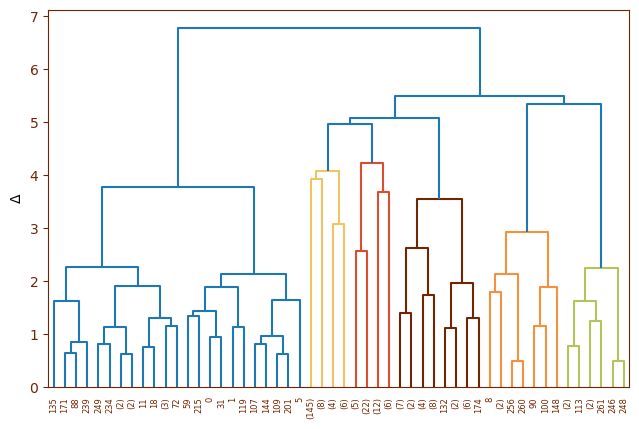

In [9]:
orig_df = pd.DataFrame(X, index=df_ing.dish_name, columns=dropped_df.columns)
Z = final_clustering(
    X_new, orig_df, 'ward', 4.5, 5, False,
    link_colors=['#1F77B4',
                 '#EFC564',
                 '#DA4D2E',
                 '#722502',
                 '#F4903E',
                 '#B3C55A']
)
y_pred = fcluster(Z, t=4.5, criterion='distance')
X_cluster = orig_df.assign(cluster=y_pred)

<center><i>Figure 4. Ward's Clustering Dendrogram Results (cut-off = <code>4.5</code>)</i></center>

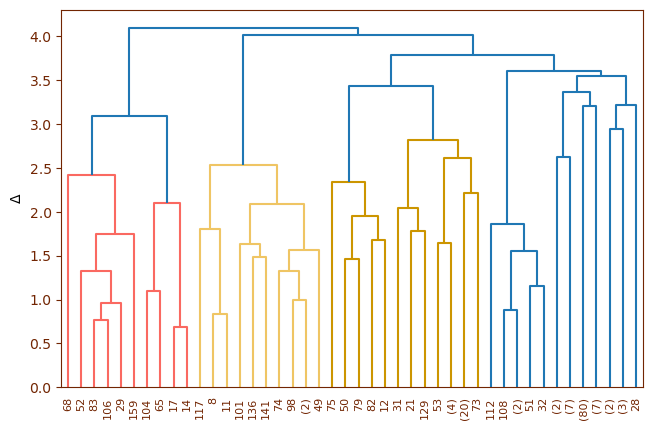

In [10]:
Z_1 = final_clustering(
    X_new, orig_df, 'ward', 4.5, 6, break_biggest_cluster=True,
    link_colors=['#FA6961',
                 '#FA6961',
                 '#EFC564',
                 '#CC9500',
                 '#CC9500',
                 '#1F77B4',
                 '#1F77B4']
)
y_pred_1 = fcluster(Z_1, t=3.7, criterion='distance')
get_big_cluster = X_cluster.groupby(['cluster']).size().idxmax()
X_cluster_1 = (
    X_cluster[X_cluster.cluster == get_big_cluster].drop(columns='cluster')
)
X_cluster_1['cluster'] = y_pred_1 + 6

<center><i>Figure 5. Zooming in on the Biggest Cluster in Figure 2 (cut-off = <code>3.7</code>)</i></center>

The Ward's method resulted in seven main ulam clusters and two clusters that were labelled together as "Others." The remaining dishes in this cluster showed a sub-cluster dominated by the presence of chicken and another relatively large sub-cluster that do not present any apparent relationship. The nature of the latter sub-cluster suggests that further clustering is possible, but the team decided to end the clustering process at this point as the insights shown by the previous clusters are substantial enough to answer the questions in the problem statement.

<h2 style="color:#DA4D2E">Descriptive Analysis</h2>

The researchers interpreted the resulting clusters by looking at the dishes' flavor, which ranged from nutty, salty, sweet, and sour; sauce, which is mainly characterized by soy sauce and vinegar-based, tomato-based, and coconut milk-based; and vegetable content, which is mainly divided by flavoring plants (e.g., garlic, pepper, bay leaf), leafy vegetables and crop vegetables. Interestingly, these criteria is also well-represented by the reduced SV components (discussed in the Results section).

A direct extension of the clustering results is the identification of ingredients that are interestingly persistent across various dishes. In here, an ingredient is considered "persistent" if it appeared in at least four out of the seven main ulam clusters -- making the ingredient a viable choice to be included in the Filipino pantry. This approach assures that all ingredients in the pantry are vital enough to be included in most of the clusters, and at the same time flexible enough to appear across wildly different clusters.

In [11]:
# Appending cluster no and cluster names to orig df
X_cluster.loc[X_cluster_1.index] = X_cluster_1
renumber_cluster = dict(zip(sorted(X_cluster['cluster'].unique()), range(9)))
X_cluster['cluster_no'] = (
    X_cluster['cluster'].map(renumber_cluster).astype(str)
)

rename_cluster = dict(zip(sorted(X_cluster['cluster_no'].unique()),
                          ['Saucy Crops', 'Others', 'Soy Vinegar',
                           'Nutty Sauce', 'Sour Soup', 'Red Sweet',
                           'Salty Soup', 'Soy Sweet', 'Others']))
X_cluster['cluster_name'] = (
    X_cluster['cluster_no'].map(rename_cluster).astype(str)
)

# Appending cluster no and cluster names to transformed df
X_new_df = pd.DataFrame(X_new)
X_new_df.columns = [f'SV{i+1}' for i in X_new_df.columns]
X_new_df['cluster_no'] = list(X_cluster['cluster_no'])
X_new_df['cluster_name'] = list(X_cluster['cluster_name'])
X_new_df['Dish Name'] = X_cluster.index

<h1 style="color:#722502">Results</h1>

<h2 style="color:#DA4D2E">The Natural Ingredient Combinations Found in Filipino Dishes</h2>

Pinoy dishes are known for their variety -- from the ingredients used down to the techniques. By performing SVD, underlying patterns relating to how the ingredients are used together in Filipino dishes are discovered, which are shown in the succeeding plots. Can you tell the Filipino dishes that will score high on the following components? In other words, can you tell which Filipino dishes are captured by the following ingredient combinations?

In [12]:
def custom_color(x):
    if x < 0:
        return '#DA4D2E'


p = plot_svd_ulam(
    data=weights_df,
    num_comp=1,
    num_ing=8,
    fill_fn=np.vectorize(custom_color),
    manual_fill_values=['#DA4D2E']
)

p.save(filename="SV1.png", width=7.5, height=5, units='in')

<center><font size=5>Dishes that are</font> <font color=#DA4D2E size=5><b>loaded with Garlic and Pepper<b></font> <font size=5>go together</font></center>

<center><img src='SV1.png' width='620px'/></center>

<br>
    
<center><i>Figure 6. Interpretation of <code>SV1</code> from the Ingredient Dataset</i></center>
        
The first SV component describes a strong positive correlation across all ingredients. Dishes that stand out in this component are those that use chicken as its protein and those loaded with garlic and pepper. Beyond that, however, no clear cut dish can be surfaced from this component. While this explains most of the ingredients' variation across the Filipino dishes at $16.6\%$, it may not be helpful in terms of taking the visual projection of the clusters.

In [13]:
def custom_color(x):
    if x < 0:
        return '#722502'
    if x > 0:
        return '#DA4D2E'


p = plot_svd_ulam(
    data=weights_df,
    num_comp=2,
    num_ing=8,
    fill_fn=np.vectorize(custom_color),
    manual_fill_values=['#722502', '#DA4D2E']
)

p.save(filename="SV2.png", width=7.5, height=5, units='in')

<center><font color="#722502" size=5><b>Soy Sauce, Garlic, and Bay Leaf</b></font> <font size=5>go together, <br>while</font> <font color=#DA4D2E size=5><b>Potato, Carrot, and Bell Pepper<b></font> <font size=5>go together</font></center>

<center><img src='SV2.png' width='620px'/></center>

<br>
    
<center><i>Figure 7. Interpretation of <code>SV2</code> from the Ingredient Dataset</i></center>
      
While `SV1` did not show any anti-correlation, `SV2` starts that trend by showing soy sauce and bay leaf on the negative end of the spectrum, and potato, carrots, and bell pepper on the postive end. Adobo is definitely a top-of-mind dish upon looking at the left side, but Lechon Paksiw and Humba are the other dishes that have the same ingredients. On the other side, the ingredients seem to be consistently present in the widely-debated dishes: Afritada, Kaldereta, and Mechado. Another interesting to note is that this SV shows a spectrum of the type of vegetable used, going from leafy vegetables to root crops.

In [14]:
def custom_color(x):
    if x < 0:
        return '#8D9F38'
    if x > 0:
        return '#DA4D2E'


p = plot_svd_ulam(
    data=weights_df,
    num_comp=3,
    num_ing=8,
    fill_fn=np.vectorize(custom_color),
    manual_fill_values=['#8D9F38', '#DA4D2E']
)

p.save(filename="SV3.png", width=7.5, height=5, units='in')

<center><font color="#8D9F38" size=5><b>Bok Choy, Papaya, and Pepper Leaf</b></font> <font size=5>go together, <br>while</font> <font color=#DA4D2E size=5><b>Carrot, and Bell Pepper<b></font><font size=5>go together</font></center>

<center><img src='SV3.png' width='620px'/></center>

<br>
    
<center><i>Figure 8. Interpretation of <code>SV3</code> from the Ingredient Dataset</i></center>
    
Bok Choy, Pepper Leaf and Chicken Stock may be found on the left side of `SV3`, while carrots and bell peppers can be found on the right. The right-side combination seems familiar when compared to the previous SV, while the left-side combination implies a soupy meal, such as Tinola. This suggests the consistency of the dish, from being a watery soup to having a more viscous texture.

In [15]:
def custom_color(x):
    if x < 0:
        return '#8D9F38'
    if x > 0:
        return '#DA4D2E'


p = plot_svd_ulam(
    data=weights_df,
    num_comp=4,
    num_ing=8,
    fill_fn=np.vectorize(custom_color),
    manual_fill_values=['#722502', '#F4903E']
)

p.save(filename="SV4.png", width=7.5, height=5, units='in')

<center><font color="#722502" size=5><b>Soy Sauce and Bay Leaf</b></font> <font size=5>go together, <br>while</font> <font color=#F4903E size=5><b>Bok Choy, Peanut, and Bagoong<b></font> <font size=5>go together</font></center>

<center><img src='SV4.png' width='620px'/></center>

<br>
    
<center><i>Figure 9. Interpretation of <code>SV4</code> from the Ingredient Dataset</i></center>
    
`SV4` shows a mix of Bok Choy, Pepper Leaf and Chicken Stock may be found on the left side of `SV3`, while carrots and bell peppers can be found on the right. The right-side combination seems familiar when compared to the previous SV, while the left-side combination implies a soupy meal, such as Tinola. This suggests the consistency of the dish, from being a watery soup to having a more viscous texture.

In [16]:
def custom_color(x):
    if x < 0:
        return '#5E6A25'
    if x > 0:
        return '#8D9F38'


p = plot_svd_ulam(
    data=weights_df,
    num_comp=5,
    num_ing=8,
    fill_fn=np.vectorize(custom_color),
    manual_fill_values=['#F4903E', '#8D9F38']
)

p.save(filename="SV5.png", width=7.5, height=5, units='in')

<center><font color="#F4903E" size=5><b>Garlic, Peanut, and Bagoong</b></font> <font size=5>go together,<br>while</font> <font color=#8D9F38 size=5><b>Okra and Kangkong<b></font> <font size=5>go together.</font></center>

<center><img src='SV5.png' width='620px'/></center>

<br>
    
<center><i>Figure 10. Interpretation of <code>SV5</code> from the Ingredient Dataset</i></center>

Lastly, `SV5` presents a combination of okra, sinigang mix, and kangkong, which are the main ingredients of our well-loved sour dish: Sinigang. The left side combination seems to be same with the earlier relationship presented in `SV4`. This SV suggest an existing spectrum of various flavors, ranging from nutty flavor, going to salty and sweet, and finally hitting sour at the edge.

<h2 style="color:#DA4D2E">Ingredient-based Clusters of Filipino Dishes</h2>

The chosen clustering technique yielded eight ingredient-based groupings of Filipino dishes. Differences in taste, flavor, vegetable components, and liquid consistency were found. With interpretability in mind, the team chose two SV components that have an evident spectrum, which are `SV2` and `SV5`. The combination of these SVs cumulatively explains $9.81\%$ of the data variation. Below is a scatter plot that shows that projection.

<font size=5> Filipino dishes were clustered into </font><font color="#DA4D2E" size=5><b>7 main groups</b></font> <font size=5> based on their </font><font color="#DA4D2E" size=5><b> taste and flavor profile, consistency, and vegetable content.</b></font>

<font color="black">Each <b>point</b> in the scatter plot represents a <b>Filipino dish</b>. The different <b>colors</b> represent the different <b>groupings</b> or clusters of the dishes based on similarity of ingredients. The <b>horizontal position</b> indicates indicates the kinds of <b>vegetables</b> in the dish (from leafy vegetables to carrots and potatoes), while the <b>vertical position</b> indicates the dominating <b>flavor of the dish</b> (from nutty, sweet, salty, and sour).</font>

In [17]:
def custom_color(x):
    if x == '0':
        return '#DA4D2E'  # carrot + patatas, ma-sarsa
    elif x == '3':
        return '#F4903E'  # dahon, ma-sarsa
    elif x == '4':
        return '#8D9F38'  # dahon, ma-sabaw
    elif x == '6':
        return '#EFC564'  # carrot + patatas, ma-sabaw
    elif x == '2':
        return '#722502'  # suka + toyo, maalat
    elif x == '7':
        return '#cc9500'  # suka + toyo, matamis
    elif x == '5':
        return '#FA6961'  # tomato-based, matamis
    else:
        return 'rgba(249, 248, 252, 0.4)'


func = np.vectorize(custom_color)
X_new_df['plotly_colors'] = func(X_new_df['cluster_no'])
X_new_df['cluster_name'] = (
    pd.Categorical(
        X_new_df['cluster_name'],
        ['Saucy Crops', 'Nutty Sauce', 'Sour Soup', 'Salty Soup',
         'Soy Vinegar', 'Soy Sweet', 'Red Sweet', 'Others'],
        ordered=True
    )
)
dict_df = X_new_df[['cluster_name', 'plotly_colors']].drop_duplicates()
cmap = dict(zip(dict_df['cluster_name'], dict_df['plotly_colors']))

plotly_ulam(data=X_new_df,
            x='SV2', y='SV5', c='cluster_name',
            y_ref=0, x_ref=0, c_map=cmap)

<center><i>Figure 11. Ingredient-based Clusters Projected on the Ingredient Space</i></center>

<img src='saucy_crops.png'/>

Dishes in this cluster are characterized by sauce with a base of tomato or coconut milk. The dishes here are also relatively spicy due to the usage of chili and pepper in the recipes. Filipinos love serving these dishes in family meals and even in gatherings. These are usually paired with steaming hot white rice, so the flavors are strong. There is also a notable lack of leafy vegetables here, but crops like potatoes and carrots are used by most. One reason that this is usually what is served by home cooks is that they are relatively easy to make and do not require much attention. Most of the ingredients are essentially just put in one pot and cooked together. Delicious meals do not need to be complex!

What do you think of Ginataang Kalabaw (Carabao Meat) with potato and chili? 

<img src='nutty_sauce.png'/>

The main ingredient here is nuts which tastes unique. It is usually eaten as either a snack or as a garnish, but rarely as the main ingredient. It is so rare that among the dishes that were part of this study, only one utilizes nuts this way. This cluster might as well be called the Kare-Kare cluster, as all the dishes here are variants of the popular Filipino dish. To further show how unique Kare-Kare is, the Nutty Sauce cluster is farthest from all of the other clusters. Since there is not much variety in this cluster yet, it could be indicative of opportunities to create recipes that utilize nuts as its main ingredient.

What do you think of sautéed chicken thigh fillet in soy sauce, sugar, and nuts?


<img src='sour_soup.png'/>

The dishes here have sour soup and leafy vegetables. Tell the words sour, soup, and vegetables in conjunction to a Filipino and only one particular dish will come up – Sinigang. The world famous Sinigang has become even more famous recently due to viral social media posts that rank this beloved Filipino dish as the number one vegetable soup in the world. It is unique even in the Filipino cuisine, and this is apparent when all the dishes that were grouped in the sour soup cluster are different versions of Sinigang. It is also notable that Sinigang’s protein is usually pork or beef. Considering we did not include fish dishes in this study, there is a lack of a chicken variant.

What do you think of Tinolang Manok with sinigang mix and Sampaloc?

<img src='salty_soup.png'/>

Dishes here are generally salty. The presence of leafy vegetables is also notable here as they balance the saltiness with their blandness and hint of bitterness. These dishes are popular to serve in relatively large households because the effort to make a large number of salty soup dishes is the same as cooking up a smaller batch. The dishes here are also relatively simple to make. In terms of variety, there is a lot of space for experimentation because dishes with a large amount of soup usually go well with many different vegetables. One interesting to note is that in terms of similarity, Pochero and Nilaga are closer compared to Sinigang and Nilaga. Both Pochero and Nilaga belong in the salty soup cluster, while Sinigang is in the sour soup cluster.

What do you think of Nilagang Baka, but the beef is seared and basted in butter and beef fat, and served separate from the soup?


<img src='soy_vinegar.png'/>

There is a fine line between the two soy clusters, which makes a lot of sense because dishes from the soy vinegar cluster and soy sweet cluster are similar, but share a key difference in that the former has vinegar and the latter does not. This cluster is headlined by none other than the world-renowned Adobo. The soy sauce and vinegar combination give so much bold flavor that Filipinos love. It is also notable that grouped in this cluster are the deep-fried Filipino dishes. At first, it was puzzling to us why adobo and crispy pata would be clustered together under soy vinegar when they share very few similarities and the latter is dry. Then we remembered, what else do we use as dips for these? The answer would be some kind of soy sauce and vinegar mixture with chili, onion, and tomatoes!

What do you think of Adobo, but instead of vinegar, we use sinigang mix?


<img src='soy_sweet.png'/>

The soy sweet cluster has dishes that usually have sugar or soft drinks as part of the recipe. It could be in the actual sauce of the dish, or the marinade of the meat. Sweet and salty is another combination of flavors that Filipinos love. Soy sauce is the choice for the salty component because other alternatives such as salt is a bit too salty for the dish, considering that the emphasis on the dishes in this cluster is on the meat and the sauce. There are no vegetables here to balance the taste with their blandness. Our creativity in cooking is shown in the recipes that use soft drinks instead of sugar. It works as it gives not only the sweetness that our palate is craving for, but it also adds just the right amount of zest flavor that gives the dish an additional twist.

What do you think about slow-cooked beef ribs in sauce made of Mountain Dew, Banana Ketchup, Soy Sauce, and star anise?


<img src='red_sweet.png'/>

Red is the most dominant color in the tables of a typical Pinoy handaan. Tomatoes have a slightly sour and bland taste, which really does not do well for a Filipino Palate because we want strong flavors. For us, it is not sour if it is not on the Sinigang level of sourness. What to do with the tomatoes then? We make it sweet! There is a Filipino style variant of all kinds of tomato-based and pasta sauces in the Philippines, which just means a sweeter version. The reason why the spaghetti and other red-sauce dishes in your neighbor’s celebration taste similar is because they use the same Filipino style sauce for both. In addition to this, cooking dishes under this cluster usually comes with another Pinoy ingredient; banana ketchup. Banana ketchup is probably the Filipino’s greatest contribution to the culinary world, here is a link if you want to know why. Overall, this cluster is usually the most cost-efficient as one can buy large quantities of the pinoy-style sauces for a cheaper price and use it on different dishes.

What do you think of deep-fried chicken wings dipped in sauce made of banana ketchup, butter, and chili? 	


<img src='others.png'/>

The remaining dishes in this cluster showed a sub-cluster dominated by the presence of chicken and another relatively large sub-cluster that do not present any apparent relationship, as it includes a mix of Chinese-influenced dishes, including shanghai, siomai, and pancit; as well as dishes that use insides, including papaitan and dinuguan. As mentioned in the Methodology section, the researchers decided to not perform any further clustering to avoid committing the bias of data dredging.


<h2 style="color:#DA4D2E">The Filipino Pantry</h2>

<center><img src='pantry.png' width='75%'/></center>

<br>

<center><i>Figure 12. Items that Make Up the Filipino Pantry</i></center>

<br>

At the core of the diversity, creativeness, and boldness of Filipino Cuisine are some ingredients that a Filipino household can easily get a hold of. Through this study, we have unlocked the secret to making a truly Filipino Pantry. With this list of ingredients, different dishes from different clusters can already be made (see Appendix Figure 2 for reference).

From the clustering, we saw how Filipino dishes tend to have a generous amount of sauce. It makes sense to build from the basic seasonings and ingredients that we use for this like sugar, salt, pepper, soy sauce, vinegar, and fish sauce. Most of our dishes are also meat-heavy, so a mix of beef, pork, and chicken is a necessity as well. In addition to this, the majority of our dishes include sautéing onion and garlic for that unique flavor and aroma, so these two vegetables are important to have. As for the vegetables, green beans and potato are the most common ingredients as they both go well with strong-tasting dishes because their blandness balances the taste out. While technically a fruit, tomatoes are sometimes considered vegetables. We always have this in the Pinoy pantry because it is used as the base for the sauce of some of our dishes (alternatively, we can use tomato sauce, too). We also love chili, so this is a must in a Pinoy pantry as this is commonly used in dips that complement a meat dish. To complete the list would be bay leaf and calamansi. Bay leaves are used in dishes for its aroma while cooking, although it is not usually eaten. Calamansi is our native lime-flavored ingredient that has a unique taste and is present in many of our dishes.

Get all ingredients from this list, and you'll have yourself a truly Pinoy pantry ready for a sudden craving for a random Filipino dish!


<h1 style="color:#722502">Discussion and Recommendations</h1>

The inspiration of this project came from the Menudo-Afritada-Caldereta-Mechado debate. Initially, the group was curious how a data science approach would fare in determining the difference between four of the most popular Filipino dishes. However, young as we are in the field of Data Science, we have the mindset of contributing to its growth, in whatever way possible, in whatever way we can. One of the biggest misconceptions about Data Science is that it is only for complicated and intricate topics because of complex mathematics and programming. Our group wanted to show that even in things that may seem ordinary, we can find a space for data science and use it to come up with results that are equally intriguing and relatable. So, we decided to expand our data and extend the analysis to Filipino dishes. 
If there is one thing that Filipino cuisine will never lack, it will be diversity. Throughout the years, our food’s unique flavors and boldness were shaped by our history, improved by our creativity, and expanded by our ingenuity. One of the most profound experiences that one can have in the Philippines is going to as many different places and trying out as many dishes. It is where true Filipino cuisine can be experienced. But as we are currently experiencing a pandemic, we have to settle for making home-cooked meals for ourselves and our household. So, we hope that the project gave the readers new ideas and possible twists to their usual Filipino food.

The study was able to cover the common Filipino chicken, pork, and beef dishes from Panlasang Pinoy. After trying different clustering techniques, Ward’s method was the one that gave us a grouping that has a good distinction between the clusters and apparent similarities across dishes that were grouped. We also used Singular Value Decomposition to help us with reducing the dataset size and with the interpretation of the clusters formed. Ultimately, the clusters were defined by the dominant flavor and texture of the dishes in them.

There were 7 main clusters formed. The eighth cluster was composed mostly of chicken dishes and other dishes with no clear relationship other than they are generally salty. Sour soup cluster or the Sinigang cluster has a soup with a sour taste and contains leafy vegetables and beans. Saucy crops cluster are dishes with tomato or coconut milk-based sauce with potatoes and carrots. Salty soup is characterized by the salty soup taste and usually comes with leafy vegetables, potatoes, and carrots. Nutty Sauce is characterized by its peanut-y taste and usually comes with leafy vegetables and eggplant. Soy vinegar comes with soy and vinegar-based sauce or a dip made from the same condiments. Red sweet uses Pinoy-style sauces and banana ketchup as the base of the sauce. Soy sweet has sauces that are soy and sugar-based. As the group interpreted the dishes based on how they were grouped, we also gathered the most common ingredients across the clusters to come up with a fully Pinoy pantry.

What started as supposedly just a fun activity to do turned into a full-blown project for us. As we got the results, practical applications were apparent, and potential business value is present. For the Filipino household, they can use the result to pick out the cost-efficient combination of dishes to serve in gatherings or a family meal. A larger quantity of ingredients usually comes at a cheaper price per unit. Having dishes that share ingredients will come at a lower cost and be easier to prepare. Since the clusters are dominantly defined by flavor and texture, it will also be easier to make a roster of food that will cover the desires of the Filipino palate without being redundant in taste. Finally, there is a space for innovation and reinvention of traditional recipes. The study showed similarities and differences between food groups, so it would not be a surprise to see new dishes or recipes created from a combination of a data-driven curiosity and a culinary sense.

There is so much potential for innovation in the food industry, and it can only get better once data science gets fully integrated into it. We are excited to be a part of this change when it happens.  


<h1 style="color:#722502">References</h1>

<a id="ref2" href="https://www.vogue.com/article/filipino-food-philippines-cuisine-restaurants">[1] McNeilly, C. (2017, June 1). How Filipino Food is Becoming the Next Great American Cuisine. Vogue. https://www.vogue.com/article/filipino-food-philippines-cuisine-restaurants </a>

<a id="ref2" href="https://books.google.com.ph/books?id=HUaDoUF0tRwC&q=%22Philippine+Cuisine%22+influences&pg=PA12&redir_esc=y#v=snippet&q=%22Philippine%20Cuisine%22%20influences&f=false">[2] Alejandro, Reynaldo (1985). The Philippine cookbook. New York, New York: Penguin. pp. 12–14. ISBN 978-0-399-51144-8.</a>

<h1 style="color:#722502">Appendix</h1>

<center><i>Table 1. Groupings of Ingredients with Corresponding Keywords</i></center>

| <center><b>Ingredient Group (feature)</b></center> | <center><b>Keywords</b></center> |
|:---|:---|
|`yeast`| "yeast"|
|`wrapper`| "wrapper"|
|`worcestershire_sauce`| "worcestershire"|
|`winged_bean`| "winged bean"|
|`vinegar`| "vinegar"|
|`turmeric`| "tumeric"|
|`tomato`| "tomato"|
|`tofu`| "tofu"|
|`toasted_rice_powder`| "toasted rice powder"|
|`taro`| "taro"|
|`sweet_potato`| "sweet potato"|
|`sugar`| "sugar"|
|`star_anise`| "star anise"|
|`squash`| "kalabasa", "squash"|
|`soy_sauce`| "soy sauce"|
|`sinigang_mix`| "sinigang"|
|`shortening`| "shortening"|
|`sesame_oil`| "sesame oil"|
|`scallion`| "scallion"|
|`sayote`| "sayote"|
|`salted_egg`| "salted egg"|
|`safflower_oil`| "safflower oil"|
|`raisins`| "raisins"|
|`radish`| "radish"|
|`potato`| "potato"|
|`pork_insides`| "pig’s liver", "pig’s heart", "pig’s small intestine", "bung", "pig cheeks", "pig heart", "pig kidney", "pig stomach", "pork ears", "pork large intenstine", "pork liver", "small intestine"|
|`pork_fat`| "pork fat"|
|`pork_stock`| "pork broth", "pork stock", "pork cube"|
|`pork_blood`| "pork blood"|
|`pork_and_beans`| "pork and beans"|
|`pie_crust`| "pie"|
|`pickle`| "pickle", "relish"|
|`pepper_leaf`| "pepper leaves"|
|`pechay`| "pechay"|
|`peanut`| "peanut"|
|`patola`| "patola"|
|`parsley`| "parsley"|
|`paprika`| "paprika"|
|`papaya`| "papaya"|
|`oyster_sauce`| "oyster"|
|`onion`| "onion"|
|`olive_oil`| "olive oil"|
|`olive`| "olive"|
|`okra`| "okra"|
|`nutmeg`| "nutmeg"|
|`noodle`| "noodle", "pancit", "sotanghon", "misua", "miswa"|
|`mushroom`| "mushroom"|
|`munggo`| "mung"|
|`mirin`| "mirin"|
|`mayonnaise`| "mayonnaise"|
|`malunggay`| "malunggay"|
|`liver_spread`| "liver"|
|`lemongrass`| "lemongrass"|
|`leeks`| "leeks"|
|`lechon_sauce`| "lechon"|
|`kasubha`| "kasubha"|
|`kangkong`| "spinach", "kangkong"|
|`jicama`| "jicama"|
|`jackfruit`| "jackfruit"|
|`ice`| "ice"|
|`hotdog`| "hotdog"|
|`hot_sauce`| "hot"|
|`honey`| "honey"|
|`hoisin_sauce`| "hoisin"|
|`green_pea`| "green pea", "pigeon pea"|
|`green_bean`| "green beans", "sitaw", "snake beans", "string beans", "snap pea", "snow pea"|
|`glutinous_rice`| "glutinous rice"|
|`ginger`| "ginger"|
|`ginataang_gulay_mix`| "ginataang"|
|`garlic`| "garlic"|
|`flour`| "flour"|
|`eggplant`| "eggplant", "talong"|
|`egg`| "egg"|
|`curry_powder`| "curry"|
|`cucumber`| "cucumber"|
|`cream`| "cream"|
|`cooking_wine`| "wine"|
|`cooking_oil`| "cooking oil", "vegetable oil"|
|`coconut_water`| "coconut water"|
|`coconut_milk`| "coconut cream", "coconut milk"|
|`coconut_meat`| "coconut meat"|
|`clear_soda`| "7-up", "sprite", "clear softdrink"|
|`cinnamon`| "cinnamon"|
|`sausage`| "chinese sauage", "chorizo"|
|`chicken_stock`| "chicken broth", "chicken cube"|
|`chicharon`| "chicharon"|
|`cheese`| "cheese"|
|`celery`| "celery"|
|`carrot`| "carrot"|
|`canned_meat`| "potted meat", "luncheon meat"|
|`calamansi`| "calamansi", "lemon", "lime"|
|`cabbage`| "cabbage"|
|`butter`| "butter", "margarine"|
|`broccoli`| "broccoli"|
|`bread`| "bread"|
|`bok_choy`| "bok choy", "bokchoy"|
|`black_soda`| "coke", "cola"|
|`black_bean`| "black bean"|
|`beer`| "beer"|
|`beef_insides`| "lard", "cow", "beef heart", "beef kidney", "beef large instestine", "beef liver", "beef neck bone", "beef small intestine", "bile", "tripe", "tongue", "tripe", "lengua"|
|`beef_stock`| "beef cube", "beef bouillon", "bulalo", "beef broth", "beef stock"|
|`bay_leaf`| "bay"|
|`bamboo_shoots`| "bamboo shoots"|
|`baking_powder`| "baking powder"|
|`annatto`| "annatto"|
|`ampalaya`| "ampalaya"|
|`adobo_sauce`| "adobo"|
|`achiote`| "achiote"|
|`tomato_liquid`| "ketchup", "tomato sauce", "tomato paste", "spaghetti sauce"|
|`banana_flower`| "blossom"|
|`pepper`| "white pepper", "black pepper", "crushed pepper", "peppercorn"|
|`chili`| "chili", "pepper flakes", "serrano pepper", "sili", "jalapeno", "ghost pepper", "green pepper"|
|`bell_pepper`| "bell pepper"|
|`bagoong`| "alamang", "shrimp paste", "balaw"|
|`liquid_seasoning`| "liquid seasoning", "savorrich", "marinade"|
|`chickpea`| "chick pea", "garbanzos"|
|`chicken_insides`| "chicken gizzard", "chicken hear", "chicken liver"|
|`cornstarch`| "cornstarch"|
|`corned_beef`| "corned beef"|
|`fish_sauce`| "fish sauce"|
|`pineapple_juice`| "pineapple juice", "juice from the canned tidbits"|
|`shrimp_cube`| "shrimp cube"|
|`watermelon`| "watermelon"|
|`milk`| "milk"|
|`pea`| "pea"|
|`pasta`| "spaghetti", "macaroni"|
|`shrimp`| "shrimp"|
|`pineapple`| "pineapple"|
|`water`| "water"|
|`salt`| "salt"|
|`rice`| "rice", "sinangag"|
|`pork`| "pork", "pig", "lechon"|
|`corn`| "corn"|
|`chicken`| "chicken"|
|`beef`| "beef", "steak", "oxtail", "ox tail", "sirloin", "bistek"|
|`banana`| "banana", "plantain"|

In [18]:
clusters = (
    X_cluster.reset_index().groupby('cluster_name')['dish_name'].unique()
)
for k, v in enumerate(clusters):
    print(f'Cluster: {clusters.index[k]}')
    print(v)
    print('--------')

Cluster: Nutty Sauce
['How to Cook Chicken Kare-Kare sa Gata' 'Chicken Kare Kare Recipe'
 'Crispy Kare-kare Recipe' 'How To Make Pata Kare-Kare'
 'Pork Kare Kare Recipe' 'Bulalo Kare-kare' 'Oxtail Kare-Kare Recipe'
 'Beef Short Rib Kare Kare']
--------
Cluster: Others
['Chicken Binagoongan Recipe' 'Spicy Sotanghon Chicken Soup'
 'Pininyahang Manok Recipe (Pineapple Chicken)'
 'Chicken Feet in Oyster Sauce with Salted Black Beans'
 'Maxs Style Fried Chicken with Kamote Fries'
 'Chicken Sotanghon Soup with Malunggay and Sayote'
 'Chicken Lollipop Recipe' 'Chicken Mami Recipe'
 'Quick and Easy Fried Chicken' 'Pinoy Fried Chicken Recipe'
 'Ginataang Manok with Papaya'
 'Chicken Liver and Gizzard Stew with Quail Eggs and Snap Peas'
 'Chicken Pancit Habhab' 'Chicken Bicol Express' 'Chicken Lumpia'
 'Chicken Sotanghon Soup' 'Inasal' 'Chicken Pancit Recipe'
 'Creamy Chicken Sopas' 'How to Cook Chicken Pastel'
 'Ginataang Manok with Kalabasa Recipe' 'Chicken Tinola Recipe'
 'Chicken Hamonado' '

<center><i>Figure 1. Complete List of Dishes per Ingredient-based Clusters</i></center>

<center><i>Table 2. List of Ingredients Present in At Least Four Ingredient-based Clusters </i></center>

In [19]:
cluster_list = (
    X_cluster['cluster_name']
    .unique()[X_cluster['cluster_name'].unique() != 'Others']
)
pantry_ing = get_cluster_ing(X_cluster, cluster_list)
pantry_ing_counter = (
    Counter(
        [item for sublist in list(pantry_ing.values()) for item in sublist]
    )
)
pantry_ing_sorted = (
    sorted(pantry_ing_counter.items(), key=lambda x: x[1], reverse=True)
)
pantry_ing_df = (
    pd.DataFrame(
        pantry_ing_sorted,
        columns=['Ingredient', 'Number of Clusters Appeared']
    )
)
pantry_ing_df[pantry_ing_df['Number of Clusters Appeared'] >= 4]

Ingredient  Number of Clusters Appeared
0            beef                            7
1     cooking_oil                            7
2           onion                            7
3          pepper                            7
4            pork                            7
5      pork_stock                            7
6            salt                            7
7           water                            7
8      beef_stock                            6
9         chicken                            6
10         garlic                            6
11         tomato                            6
12       bay_leaf                            5
13  chicken_stock                            5
14     green_bean                            5
15      soy_sauce                            5
16          sugar                            5
17      calamansi                            4
18          chili                            4
19   coconut_milk                            4
20     fish_sauce                            4
21            ice                            4
22         potato                            4
23        vinegar                            4
24   pork_insides                            4